# Fase 3: Implementación del Control Adelanto-Atraso y Realimentación de estados

### Funcion de transferencia

Función de transferencia G(s):
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


           0.01
---------------------------
0.005 s^2 + 0.06 s + 0.1001



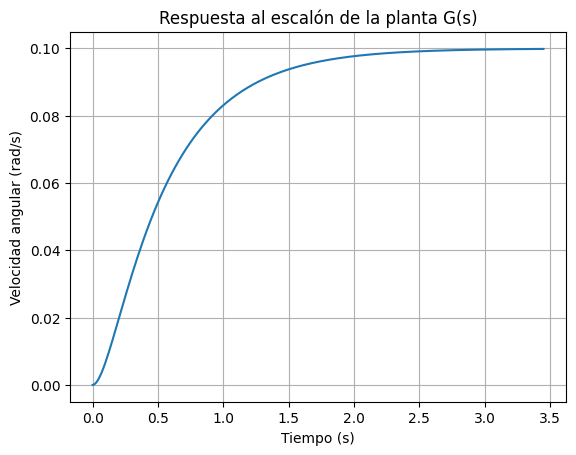

In [1]:
import control as ctrl
import matplotlib.pyplot as plt

# Parámetros físicos
J = 0.01
b = 0.1
Kt = 0.01
Ke = 0.01
R = 1
L = 0.5

# Coeficientes del denominador
num = [Kt]
den = [J*L, J*R + L*b, b*R + Kt*Ke]

# Crear la función de transferencia
G = ctrl.TransferFunction(num, den)
print("Función de transferencia G(s):")
print(G)

# Respuesta al escalón
t, y = ctrl.step_response(G)
plt.plot(t, y)
plt.title("Respuesta al escalón de la planta G(s)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad angular (rad/s)")
plt.grid(True)
plt.show()


### Modelo de espacio de estados

Sistema en espacio de estados:
<StateSpace>: sys[3]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (2): ['x[0]', 'x[1]']

A = [[-10.     1.  ]
     [ -0.02  -2.  ]]

B = [[0.]
     [2.]]

C = [[1. 0.]]

D = [[0.]]



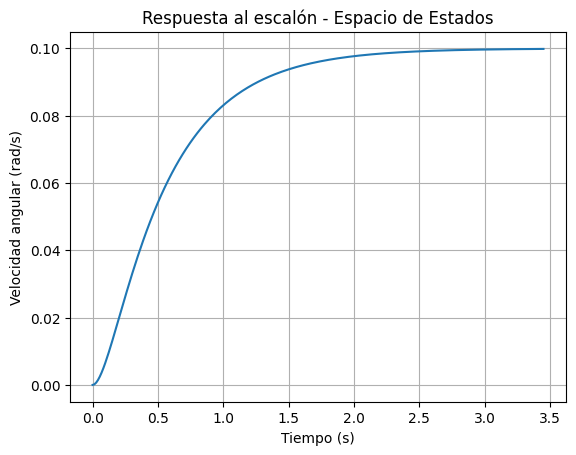

In [2]:
import numpy as np

# Matrices del sistema
A = np.array([[-b/J,    Kt/J],
              [-Ke/L,  -R/L]])

B = np.array([[0],
              [1/L]])

C = np.array([[1, 0]])
D = np.array([[0]])

# Crear el sistema en espacio de estados
sys_ss = ctrl.ss(A, B, C, D)
print("Sistema en espacio de estados:")
print(sys_ss)

# Respuesta al escalón
t, y = ctrl.step_response(sys_ss)
plt.plot(t, y)
plt.title("Respuesta al escalón - Espacio de Estados")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad angular (rad/s)")
plt.grid(True)
plt.show()


### Identificacion experimental del modelo

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos reales
df = pd.read_csv("datos_rpm.csv")

# Filtrar segmento donde se aplicó un escalón (puedes ajustar el rango)
# Por ejemplo, del segundo 0.5 al 2.5
df_seg = df[(df['time'] > 0.5) & (df['time'] < 2.5)].copy()
t = df_seg['time'].values - df_seg['time'].values[0]  # reiniciar tiempo desde 0
y = df_seg['rpm_rad'].values

# Graficar la respuesta real
plt.plot(t, y, label='Respuesta real')
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (rad/s)")
plt.title("Respuesta real del motor ante escalón")
plt.grid(True)
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'datos_rpm.csv'